In [1]:
from datascience import *
import numpy as np
import pandas as pd
from math import *
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Lesson 35: Regression

Over the last two lessons, you went over regression in Data 8.3x. In these sections, you learned how to calculate the slope and intercept of a line fit to a bivariate sample. For example, using the `baby.csv` dataset, you can use regression to predict birthweight given the gestational age of the baby at birth. 

### Exercise 1

Find the least squares line that predicts birthweight based on the gestational age of a baby. You should use `minimize`, an optimization method in the `datascience` package. Note that you could use standardization (similar to what they did in Data 8.3x, `lec7.ipynb`) but the resulting intercept and slope would be in standardized units, and would need to be transformed in order to be interpretable. 

In [2]:
baby = Table.read_table('baby.csv')
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


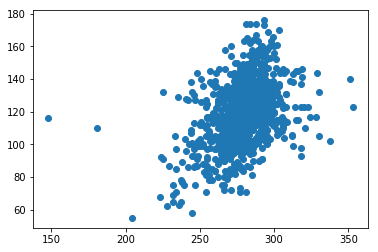

In [3]:
plt.scatter(baby.column(1),baby.column(0))
plt.show()

In [4]:
def fitline(t,xcol,ycol):
    def ErrorSquared(b1,b0):
        return sum((t.column(ycol)-t.column(xcol)*b1 - b0)**2)
    return minimize(ErrorSquared)

In [5]:
slope = fitline(baby,1,0)[0]
intercept = fitline(baby,1,0)[1]
print('The slope is', slope,'ounces per day and the intercept is',intercept,'ounces.')

The slope is 0.4284036994399658 ounces per day and the intercept is -0.07039869065605786 ounces.


In the context of the data, interpret the intercept and slope. 

The slope indicates that a baby is on average about 0.43 ounces heavier per additional day of gestation. The intercept indicates that a baby is around -0.07 ounces at zero days of gestation. This of course does not make sense as nothing has negative weight. However, it is very near zero which does make sense as an unborn child should weigh almost nothing at zero days of gestation.

The slope is 0.428. It seems reasonable to expect this slope to be significantly higher than zero; it makes sense that gestational age would impact birthweight. Let's check using bootstrapping. 

In [6]:
slopes = make_array()
intercepts = make_array()
for i in np.arange(10000):
    weight = make_array()
    ages = make_array()
    babysample = baby.sample()
    data = fitline(babysample,1,0)
    slopes = np.append(slopes,data[0])
    intercepts = np.append(intercepts,data[1])

95% confidence interval for the slope: [0.425026, 0.432337] ounces per day


C:\Users\C20Eric.Hembling\Documents\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


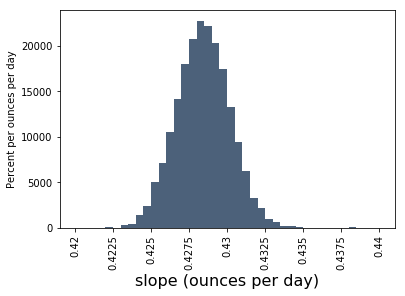

In [7]:
lower_end = np.sort(slopes)[int(len(slopes)*0.025)]
upper_end = np.sort(slopes)[int(len(slopes)*0.975)]
Table().with_column("slope", slopes).hist(bins=np.arange(0.42, 0.44, .0005), unit="ounces per day")
print("95% confidence interval for the slope: [{:g}, {:g}] ounces per day".format(lower_end, upper_end))

### Exercise 2

For a baby born at 40 weeks gestational age, what do we expect to be the average birthweight according to this model?

In [8]:
weightestimate40weeks = slope*40*7 + intercept
weightestimate40weeks

119.88263715253437

Using bootstrapping, build a 95% confidence interval around this estimate. Interpret this interval, carefully. 

95% confidence interval for the slope: [118.929, 120.854] ounces


C:\Users\C20Eric.Hembling\Documents\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


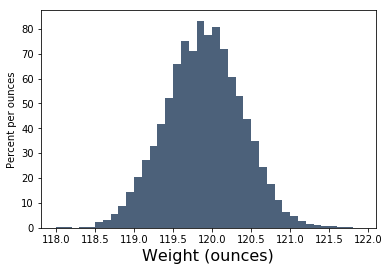

In [9]:
meanintervaldata = slopes*40*7 + intercepts
lower_end = np.sort(meanintervaldata)[int(len(meanintervaldata)*0.025)]
upper_end = np.sort(meanintervaldata)[int(len(meanintervaldata)*0.975)]
Table().with_column("Weight", meanintervaldata).hist(bins=np.arange(118, 122, .1), unit="ounces")
print("95% confidence interval for the slope: [{:g}, {:g}] ounces".format(lower_end, upper_end))

If babys are from the same population from which the baby table is collected, there is a 95% chance that the average birth weight of babys born after 40 weeks is between the values listed above. 

This is a confidence inteval on the **mean** birthweight for a baby born at 40 weeks. 

### Exercise 3

Suppose a baby is born at 40 weeks. Let's construct a confidence interval for the birthweight of *that baby*. This is different than the confidence interval on the mean birthweight of babies born at 40 weeks. This interval is known as a prediction interval. 

A simple way to find the prediction interval is to sample many times (with replacement) from the observed residuals and add to the predicted birthweight under the linear model. Find the percentiles of these simulations to obtain the interval. 

In [10]:
sampleprediction = fitline(baby,1,0)[0]*40*7+fitline(baby,1,0)[1]

In [11]:
indbabyweightest = make_array()
n = 0
for i in slopes:
    prediction = 40*7*slopes[n]+intercepts[n]
    data = prediction + (baby.where(1,40*7).column(0)[np.random.randint(len(baby.where(1,40*7).column(0)))]-sampleprediction)
    indbabyweightest = np.append(indbabyweightest,data)
    n = n+1

95% confidence interval for the weight: [96.0117, 147.029] ounces


C:\Users\C20Eric.Hembling\Documents\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


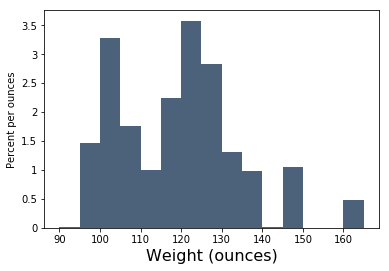

In [12]:
lower_end = np.sort(indbabyweightest)[int(len(indbabyweightest)*0.025)]
upper_end = np.sort(indbabyweightest)[int(len(indbabyweightest)*0.975)]
Table().with_column("Weight", indbabyweightest).hist(bins=np.arange(90, 170, 5), unit="ounces")
print("95% confidence interval for the weight: [{:g}, {:g}] ounces".format(lower_end, upper_end))

In [14]:
residuals  = baby[0] - sampleprediction
residuals

array([ 0.11736285, -6.88263715,  8.11736285, ..., 10.11736285,
        5.11736285, -2.88263715])

It turns out that this method is a little oversimplified. A "more correct" method is below. This requires taking into account the *leverage* of each data point (basically a measure of impact to the model of each data point). 

In [15]:
pred=intercept+slope*150
leverage=1/baby.num_rows + ((baby.column(1)-np.mean(baby.column(1)))**2)/np.sum(((baby.column(1)-np.mean(baby.column(1)))**2))
adjresiduals=residuals/np.sqrt(1-leverage)

bs_all=[]
for _ in np.arange(5000):
    bs_y=(intercept+slope*baby.column(1))+np.random.choice(adjresiduals,size=baby.num_rows,replace=True)
    resample=Table().with_columns("y",bs_y,"x",baby.column(1))
    bs_slope,bs_intercept=minimize(mse_resample)
    bs_residuals=bs_y-(bs_intercept+bs_slope*baby.column(1))
    bs_adjresiduals=bs_residuals/np.sqrt(1-leverage)
    bs_all=np.append(bs_all,150*(slope-bs_slope)+np.random.choice(bs_adjresiduals))

percentile([2.5,97.5],pred+bs_all)

NameError: name 'mse_resample' is not defined

Documentation: None. The code at the end does not run, but we were not requested to alter that section. 